In [2]:
import numpy as np
import pandas as pd
import psycopg2
import sshtunnel 
from datetime import date, time,datetime, timedelta

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from matplotlib import pyplot

In [3]:
def execute_querie_test(c,sql):
        c.execute(sql)
        #db_list = c.fetchmany()
        field_names = [i[0] for i in c.description]
        query_results = pd.DataFrame(c.fetchall(),columns=field_names)
        
        return query_results
        #print(db_list)

In [4]:
def ssh_connect(sql):
    try:
        sshtunnel.SSH_TIMEOUT = 10.0

        with sshtunnel.SSHTunnelForwarder(
                ('3.83.88.154', 22),
                ssh_username='ec2-user',
                #CHANGE PATH TO rds-example.cer
                ssh_pkey='C:/Users/Maren/Documents/rds-example.cer',
                remote_bind_address=('stib-mivb.cjo3cnpt9pci.us-east-1.rds.amazonaws.com', 5432)
        ) as tunnel:
            conn = psycopg2.connect(
                    host='127.0.0.1',
                    port=tunnel.local_bind_port,     
                    database="stibmivbdb",
                    user="postgres",
                    password="stib-mivb-db1"
            )

            c = conn.cursor()

            #EXECUTE QUERY IN DB TO TEST
            query_results = execute_querie_test(c,sql)

            c.close()
            return query_results
    except Exception as e:
        print(e)

In [5]:
#convert string to time object (deal with the times greater 23)
def getTime(time):
    hour = time[0:2]
    
    #check for times with hours > 23
    if int(hour) > 23:
        time_str = time
        new_time = time_str[0:2].replace(hour,str(0) + str(int(hour)-24)) + time_str[2:]
        c_time = datetime.strptime(new_time, '%H:%M:%S').time()
    else:
        c_time = datetime.strptime(time, '%H:%M:%S').time()
    
    
    return c_time

In [6]:
#if time is higher than 24:00 higher the date
def getDate(time,date):
    hour = time[0:2]
    #date = datetime.strptime(date, "%Y-%m-%d")
    #check for times with hours > 23
    if int(hour) > 23:
        date = date + timedelta(days=1)
        
    return date

In [34]:
def getTimeGroup(str_from):
    
    start_time = datetime.strptime('00:00:00', '%H:%M:%S')
    end_time = datetime.strptime('02:00:00', '%H:%M:%S')
    time_from = datetime.strptime(str_from, '%H:%M:%S')
    
    #end_time = start_time + timedelta(minutes=30)
    time_id = 1
    
    if time_from.time() <= datetime.strptime('22:00:00', '%H:%M:%S').time():
    
        while time_from.time() > end_time.time():
            end_time = end_time + timedelta(minutes=120)
            time_id = time_id + 1
        
        #get deltas to end start and end of time_frame
        delta_e = end_time - time_from
        delta_s = time_from - start_time
        #closer to_end next group
        if delta_e.total_seconds() < delta_s.total_seconds():
            time_id = time_id + 1
        #else:
            #Closer to this group
    else:
        time_id = 12
            
    return time_id

In [8]:
def create_dfStop(stops):
    df_stops = pd.DataFrame(stops,columns=['stop_id'])
    df_stops['stop_key'] = range(1, len(df_stops) + 1)
    
    return df_stops

In [9]:
def prepare_inputs(X,X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

In [10]:
def prepare_targets(y,y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

In [11]:
# feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [45]:
def getRegular(ewt,ewt_cat):
    #ewt_min = int(ewt_cat[0])
    ewt_max = int(ewt_cat[ewt_cat.find('MIN')-1])
    
    if ewt <= ewt_max:
        return 0
    else:
        return 1

In [62]:
#get samples
sql = """(Select rt.route_id,r.route_type,stop_id,from_date,from_time,to_date,to_time,ewt_minutes,ewt_category
from regularity_trip_timegroups_results_30 rt
inner join routes r
on r.route_id = rt.route_id
where ewt is not NULL
and r.route_type='0'
and ewt_category = '0-4MIN' or ewt_category = '4-8MIN' or ewt_category = '8-12MIN'
order by RANDOM() LIMIT 300000)
UNION
(Select rt.route_id,r.route_type,stop_id,from_date,from_time,to_date,to_time,ewt_minutes,ewt_category
from regularity_trip_timegroups_results_30 rt
inner join routes r
on r.route_id = rt.route_id
where ewt is not NULL
and r.route_type='1'
and ewt_category = '0-4MIN' or ewt_category = '4-8MIN' or ewt_category = '8-12MIN'
order by RANDOM() LIMIT 300000)
UNION
(Select rt.route_id,r.route_type,stop_id,from_date,from_time,to_date,to_time,ewt_minutes,ewt_category
from regularity_trip_timegroups_results_30 rt
inner join routes r
on r.route_id = rt.route_id
where ewt is not NULL
and r.route_type='3'
and ewt_category = '0-4MIN' or ewt_category = '4-8MIN' or ewt_category = '8-12MIN'
order by RANDOM() LIMIT 300000)"""

df_db = ssh_connect(sql)

In [63]:
df_transform = df_db
df_transform['str_from_time']=df_transform['from_time'].astype(str)
df_transform['str_to_time']=df_transform['to_time'].astype(str)
df_transform.head()

,route_id,route_type,stop_id,from_date,from_time,to_date,to_time,ewt_minutes,ewt_category,str_from_time,str_to_time
0,1,1,8012,2021-09-06,09:37:01,2021-09-06,10:07:01,1.582255,0-4MIN,09:37:01,10:07:01
1,1,1,8012,2021-09-06,10:07:01,2021-09-06,10:37:01,2.715650,0-4MIN,10:07:01,10:37:01
2,1,1,8012,2021-09-06,10:13:37,2021-09-06,10:43:37,3.070116,0-4MIN,10:13:37,10:43:37
3,1,1,8012,2021-09-06,10:14:42,2021-09-06,10:44:42,3.079025,0-4MIN,10:14:42,10:44:42
4,1,1,8012,2021-09-06,10:37:01,2021-09-06,11:07:01,2.199677,0-4MIN,10:37:01,11:07:01


In [64]:
#create timegroups of 2 hours in which entries will be grouped
time_ids = []

for ind,row in df_transform.iterrows():
    time_id = getTimeGroup(row['str_from_time'])
    time_ids.append(time_id)

df_transform['time_id'] = time_ids

#add weekday (0=monday,1=tuesday,..)
df_transform['weekday']  = df_transform.apply(lambda x: x.from_date.weekday(), axis=1)

df_transform['regular']  = df_transform.apply(lambda x: getRegular(x.ewt_minutes,x.ewt_category), axis=1)

df_transform.head()

,route_id,route_type,stop_id,from_date,from_time,to_date,to_time,ewt_minutes,ewt_category,str_from_time,str_to_time,time_id,weekday,regular
0,1,1,8012,2021-09-06,09:37:01,2021-09-06,10:07:01,1.582255,0-4MIN,09:37:01,10:07:01,6,0,0
1,1,1,8012,2021-09-06,10:07:01,2021-09-06,10:37:01,2.715650,0-4MIN,10:07:01,10:37:01,7,0,0
2,1,1,8012,2021-09-06,10:13:37,2021-09-06,10:43:37,3.070116,0-4MIN,10:13:37,10:43:37,7,0,0
3,1,1,8012,2021-09-06,10:14:42,2021-09-06,10:44:42,3.079025,0-4MIN,10:14:42,10:44:42,7,0,0
4,1,1,8012,2021-09-06,10:37:01,2021-09-06,11:07:01,2.199677,0-4MIN,10:37:01,11:07:01,7,0,0


In [65]:
#give stops an id 
stops = df_transform['stop_id'].unique()
df_stops = create_dfStop(stops)

df_transform_new = df_transform.merge(df_stops, how='inner', on='stop_id')
df_transform_new = df_transform_new[['route_id','route_type','stop_key','from_date','time_id','weekday','regular']]
df_transform_new.head()
#finished with preprocessing

,route_id,route_type,stop_key,from_date,time_id,weekday,regular
0,1,1,1,2021-09-06,6,0,0
1,1,1,1,2021-09-06,7,0,0
2,1,1,1,2021-09-06,7,0,0
3,1,1,1,2021-09-06,7,0,0
4,1,1,1,2021-09-06,7,0,0


In [66]:
#Start with mutual information 
# retrieve numpy array
dataset = df_transform_new.values
X = dataset[:, :-1]
y = dataset[:,-1]

In [67]:
#Start with mutual information 
# retrieve numpy array
dataset = df_transform_new.values
X = dataset[:, :-1]
y = dataset[:,-1]
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X,X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y,y_train, y_test)

In [68]:
# feature selection perform 50 times
scores=[]
for j in range(50):
    X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)
    # what are scores for the features
    scores.append(fs.scores_)
    #for i in range(len(fs.scores_)):
    #    print('Feature %d: %f' % (i, fs.scores_[i]))

In [69]:
#average the results of thw 50 runs
results = np.empty(len(scores[1])) 
feature = []

for i in range(len(scores[1])):
    for j in range(len(scores)):
        feature.append(scores[j][i])
        
        
    avg = sum(feature) / len(feature)
    results[i] = avg
    feature = []
    
results

array([0.02053383, 0.05344467, 0.02327414, 0.01136756, 0.0308768 ,
       0.0138042 ])

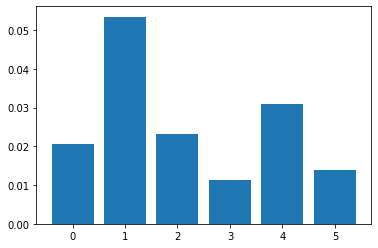

In [70]:
# plot the scores
pyplot.bar([i for i in range(len(results))], results)
pyplot.show()